I have been unable to prove that the smallest value of the Lagrange multiplier always leads to the lowest objective. Thus, I will continue checking all secular equation candidate solutions. The secular solver itself takes about 6% of a line's solution time. Mapping was taking 62%, but that was due to an enormous inefficiency. My code was recalculating the operator that maps a vector $\omega$ back to the original solution space *for each candidate*. This matrix is fixed for a particular line, so it should only be calculated once. I have fixed this error.

In [1]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere include("../src/mat2tmpinst.jl")
@everywhere using TemporalInstanton

  likely near /home/jkersulis/Documents/Dropbox/InstantonAnew/Jonas Edits/Time-Coupled Instanton/temporal-instanton/src/ThermalModel.jl:429
  likely near /home/jkersulis/Documents/Dropbox/InstantonAnew/Jonas Edits/Time-Coupled Instanton/temporal-instanton/src/ThermalModel.jl:430
  likely near /home/jkersulis/Documents/Dropbox/InstantonAnew/Jonas Edits/Time-Coupled Instanton/temporal-instanton/src/ThermalModel.jl:429
  likely near /home/jkersulis/Documents/Dropbox/InstantonAnew/Jonas Edits/Time-Coupled Instanton/temporal-instanton/src/ThermalModel.jl:430
 in WARNING: replacing module MatpowerCases
depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include_string at loading.jl:266
 in include_from_node1 at ./loading.jl:307
 in include_string at loading.jl:266
 in include_from_node1 at ./loading.jl:307
 in eval at ./sysimg.jl:14
 in anonymous at multi.jl:1350
 in anonymous at multi.jl:892
 in run_work_thunk at multi.jl:645
 [inlined code] from multi.jl:892
 in anonymous at task.

In [4]:
# compile everything with this run:
inputData = load_rts96_data(return_as_type=true);
# Thermal model parameters:
inputData.Tamb = 35. # C
inputData.T0 = 60. #46. # initial line steady-state temp

inputData.time_values = 0:30:300 # five minutes in 30-sec steps
inputData.int_length = 300. # seconds = 5 min
Gp,Dp,Rp = inputData.G0,inputData.D0,inputData.R0
inputData.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
inputData.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
inputData.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

@time results = solve_temporal_instanton(inputData);

n = length(inputData.k)
nr = length(inputData.Ridx)
T = convert(Int64,length(inputData.G0)/n)
outputData = process_instanton_results(results,n,nr,T,return_as_type=true);

sort(outputData.score)

104-element Array{Float64,1}:
    0.263788
    0.327316
    1.28861 
    2.20415 
    2.32297 
    2.42316 
    4.67876 
    4.86524 
    4.89917 
    5.67827 
    5.93862 
    6.43917 
    6.46089 
    ⋮       
  178.086   
  303.003   
  370.614   
  370.614   
  391.307   
  428.944   
  923.98    
  979.199   
 1319.85    
 1390.03    
 1967.27    
 1967.27    

0.552326 seconds (19.02 k allocations: 2.193 MB)


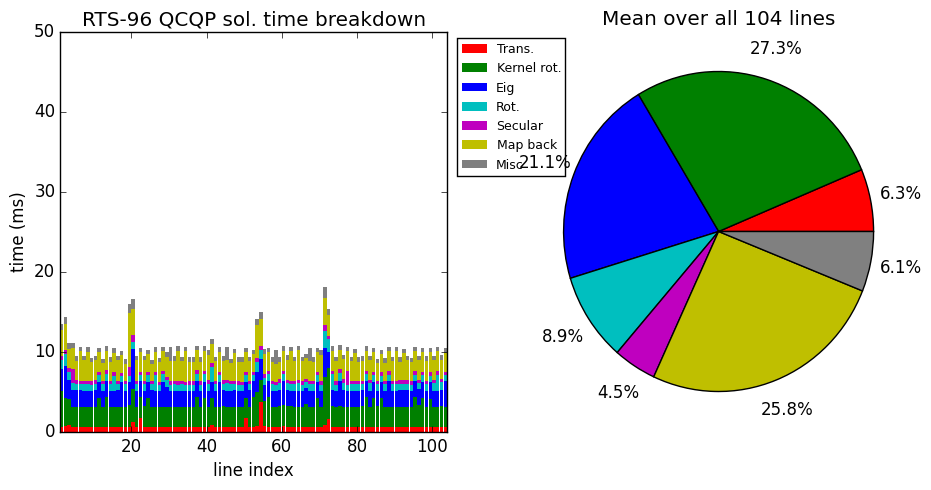

In [6]:
using PyPlot
PyPlot.svg(true)

t = load("../data/timing.jld")["timeVecs"]

tTrans    = [ti[1] for ti in t]*1e3
tKern     = [ti[2] for ti in t]*1e3
tEig      = [ti[3] for ti in t]*1e3
tRot      = [ti[4] for ti in t]*1e3
tSec      = [ti[5] for ti in t]*1e3
tMap      = [ti[6] for ti in t]*1e3
misc = outputData.linetimes*1e3 - (tMap+tSec+tRot+tEig+tKern+tTrans)

xvals = collect(1:length(tTrans))

fig = figure(figsize=(11,5))
subplot(1,2,1)
title("RTS-96 QCQP sol. time breakdown")
axis([1;length(xvals);0;50])
xlabel("line index")
ylabel("time (ms)")

bar(xvals, tTrans, color = "r", linewidth=0, width=0.9)
bar(xvals, tKern,  color = "g", bottom = tTrans, linewidth=0, width=0.9)
bar(xvals, tEig,   color = "b", bottom = tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, tRot,   color = "c", bottom = tEig+tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, tSec,   color = "m", bottom = tRot+tEig+tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, tMap,   color = "y", bottom = tSec+tRot+tEig+tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, misc,   color = "k", bottom = tMap+tSec+tRot+tEig+tKern+tTrans, linewidth=0,width=0.9, alpha=0.5)

labels = ["Trans.";
    "Kernel rot.";
    "Eig";
    "Rot.";
    "Secular";
    "Map back";
    "Misc"]

legend(labels,loc=1,ncol=1,fontsize=9,
bbox_to_anchor=(1.32, 1.0))

subplot(1,2,2)
title("Mean over all 104 lines")
sizes = [mean(tTrans);
    mean(tKern);
    mean(tEig);
    mean(tRot);
    mean(tSec);
    mean(tMap);
    mean(misc)]
scale!(sizes,1/sum(sizes))

colors = ["r";
    "g";
    "b";
    "c";
    "m";
    "y";
    "gray"]

pie(sizes, colors=colors, autopct="%1.1f%%", pctdistance=1.2)
# tight_layout()
savefig("../images/2015-10-21-timing-analysis-map-once.pdf")